In [1]:
import tensorflow as tf
import keras
from tensorflow.python.framework.ops import disable_eager_execution
import numpy as np
import os,sys
import h5py
import argparse,socket
import datetime
%load_ext tensorboard

# Clear any logs from previous runs
#!rm -rf ./logs/

In [2]:
print("tensorflow version:",tf.__version__)
print("keras version:",keras.__version__)
print("python version:",sys.version)

tensorflow version: 2.6.0
keras version: 2.6.0
python version: 3.8.0 (default, Jul 23 2021, 11:57:41) 
[GCC 9.3.0]


In [3]:
tf.debugging.set_log_device_placement(False)
#disable_eager_execution()
tf.executing_eagerly()

True

# limit gpu memory consuption 

In [4]:
print(tf.config.list_physical_devices(device_type=None))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Creates virtual GPU with 1GB memory limit
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)
print(logical_gpus) #AVX stands for Advanced Vector Extensions

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPU, 1 Logical GPUs
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2021-10-13 14:05:28.011796: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-13 14:05:28.398184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10000 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6


# global parameters

In [5]:
# working directories and paths
BASE_DIR = os.getcwd()
sys.path.append(BASE_DIR)
sys.path.append(os.path.join(BASE_DIR, 'models'))
sys.path.append(os.path.join(BASE_DIR, 'utils'))
print("BASE_DIR:",BASE_DIR)

#global parameters
MAX_NUM_POINT = 2048
NUM_CLASSES = 40
BATCH_SIZE = 32
MAX_EPOCH = 100
BASE_LEARNING_RATE =0.001
OPTIMIZER = 'adam'

GPU_INDEX = 0
MOMENTUM = 0.9
DECAY_STEP = 200000
DECAY_RATE = 0.7

BN_INIT_DECAY = 0.5
BN_DECAY_DECAY_RATE = 0.5
BN_DECAY_DECAY_STEP = float(DECAY_STEP)
BN_DECAY_CLIP = 0.99

HOSTNAME = socket.gethostname()

BASE_DIR: /home/liteandfog/pointnet


# logging

In [6]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/gradient_tape/' + current_time + '/train'
writer = tf.summary.create_file_writer(logdir)

# Data

In [7]:
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

In [8]:
# ModelNet40 official train/test split
TRAIN_FILES = [line.rstrip() for line in open(os.path.join(BASE_DIR, 'data/modelnet40_ply_hdf5_2048/train_files.txt'))]
TEST_FILES = [line.rstrip() for line in open(os.path.join(BASE_DIR, 'data/modelnet40_ply_hdf5_2048/test_files.txt'))]

current_data, current_label =  load_h5(TRAIN_FILES[1])
print(current_data.shape)
print(current_label.shape)
print("num of batches:",current_data.shape[0] // BATCH_SIZE)
print("file size:", current_data.shape[0])

(2048, 2048, 3)
(2048, 1)
num of batches: 64
file size: 2048


In [9]:
#6
Weights_tnet_shapes=[[1,3,1,64], [1,1,64,128], [1,1,128,1024], [1024,512], [512,256], [256,3**2]]

#2
Weights_layer_1_shapes=[[1,3,1,64],[1,1,64,64]]

#6
Weights_fnet_shapes=[[1,1,64,64],[1,1,64,128],[1,1,128,1024],[1024,512],[512,256],[256,64**2]]

#6
Weights_layer_2_shapes=[[1,1,64,64],[1,1,64,128],[1,1,128,1024],[1024,512],[512, 256],[256, NUM_CLASSES]]

In [10]:
def _kernel(shape):
    initializer = keras.initializers.GlorotNormal() #Xavier
    with tf.device('/cpu:0'): #save on cpu memory
        kernel=tf.Variable(name="weights",initial_value=initializer(shape=shape))
    return kernel

def _biases(output_channels):
    intializer = keras.initializers.Constant(0.0)
    with tf.device('/cpu:0'): #save on cpu memory
        biases=tf.Variable(name="biases",shape=output_channels,initial_value=intializer(shape=[output_channels]))
    return biases

def _bn(momentum):
    with tf.device('/cpu:0'): #save on cpu memory

        bn_init=keras.layers.BatchNormalization(momentum=momentum,
           beta_initializer='zeros', gamma_initializer='ones',
           moving_mean_initializer='ones', moving_variance_initializer='ones')
    return bn_init

# Keras layers 

In [11]:
class Dense(keras.layers.Layer):
    def __init__(self, shape, name=None):
        super().__init__(name=name)
        self.shape=shape
        
    def build(self,input_shape):
        self.w = _kernel(self.shape)
        self.b = _biases(self.shape[-1])
        self.bn = _bn(BN_INIT_DECAY)
        
    def call(self, x, bn=True, activation=True, is_training=True):
        y = tf.matmul(x, self.w) + self.b
        
        if bn:
            y = self.bn(y,training = is_training)
        
        if activation:
            y = tf.nn.relu(y)
        
        return y

class Conv2d(keras.layers.Layer):
    def __init__(self, shape, strides=[1,1,1,1], padding='VALID', data_format='NHWC', name=None):
        super().__init__(name=name)
        self.shape=shape
        self.strides = strides
        self.padding = padding
        self.data_format = data_format
        
    def build(self, input_shape):
        self.filters = _kernel(self.shape)
        self.bias = _biases(self.shape[-1])
        self.bn = tf.keras.layers.BatchNormalization(momentum=0.5,
        beta_initializer='zeros', gamma_initializer='ones',
        moving_mean_initializer='ones', moving_variance_initializer='ones')
        
    def call(self, inputs, bn=True, activation=True, is_training=True):
        y = tf.nn.conv2d(inputs, filters=self.filters, strides=self.strides, padding=self.padding , data_format=self.data_format)
        y = tf.nn.bias_add(y, self.bias)
        
        if bn:
            y = self.bn(y,training = is_training)
        
        if activation:
            y = tf.nn.relu(y)
        return y
    
class MaxPool(keras.layers.Layer):
    def __init__(self, batch_size=32 ,name=None):
        super().__init__(name=name)
        self.batch_size=batch_size
        
    def call(self, pcd):
        y = tf.nn.max_pool(pcd, ksize=[1, 2048, 1, 1], strides=[1, 2, 2, 1], padding='VALID')
        y = tf.reshape(y, [self.batch_size, -1])
        return y
    
class TransformMatrix(keras.layers.Layer):
    def __init__(self, shape, K, batch_size=32, name=None):
        super().__init__(name=name)
        self.shape=shape
        self.batch_size=batch_size
        self.K=K
        
    def build(self, input_shape):
        self.w = _kernel(self.shape)
        bias = _biases(self.shape[-1]).assign_add(tf.constant(np.eye(self.K).flatten(), dtype=tf.float32))
        self.b = bias
        
    def call(self, pcd):
        
        y = tf.matmul(pcd, self.w)
        y = tf.nn.bias_add(y, self.b)
        y = tf.reshape(y, [self.batch_size, self.K, self.K])
        return y #BxKxK 

# t/f net layer
class TNet(keras.layers.Layer):
    def __init__(self, weights_shape,K=3,name=None):
        super().__init__(name=name)
        self.weights_shape = weights_shape
        self.K=K
        
        
    def build(self, input_shape):     
        
        self.conv2d_1 = Conv2d(shape=self.weights_shape[0])
        self.conv2d_2 = Conv2d(shape=self.weights_shape[1])
        self.conv2d_3 = Conv2d(shape=self.weights_shape[2])
        
        self.maxpool = MaxPool()
        
        self.dense_1 = Dense(self.weights_shape[3])
        self.dense_2 = Dense(self.weights_shape[4])
        self.Transform_Matrix = TransformMatrix(self.weights_shape[-1], self.K)

    def call(self, pcd):
        
        if self.name == 'tNet':
            net = tf.expand_dims(pcd, -1)
        elif self.name == 'fNet':
            net = pcd
            
        net = self.conv2d_1(net)
        net = self.conv2d_2(net)
        net = self.conv2d_3(net)
        net = self.maxpool(net)
        net = self.dense_1(net)
        net = self.dense_2(net)
        
        t_transform = self.Transform_Matrix(net) #BxKxK
        
        
        if self.name == 'tNet':
            #t-net:t-transform
            pcd_transformed = tf.matmul(pcd, t_transform) #BxWxH
            input_image = tf.expand_dims(pcd_transformed, -1) #BxWxHx1
            return input_image, t_transform
        
        
        elif self.name == 'fNet':
            
            #f-net:f-transform 
            net_transformed = tf.matmul(tf.squeeze(pcd, axis=[2]), t_transform)#BxWx1x64 * BxWx64 = BxWx64
            net_transformed = tf.expand_dims(net_transformed, [2]) #BxWx64x1
            return net_transformed, t_transform

In [12]:
class PointNet(keras.Model):

    def __init__(self):
        super(PointNet, self).__init__()
        self.tnet = TNet(Weights_tnet_shapes, name="tNet")
        
        self.conv1_1 = Conv2d(Weights_layer_1_shapes[0])
        self.conv1_2 = Conv2d(Weights_layer_1_shapes[1])
        
        self.fnet = TNet(Weights_fnet_shapes, K=64,name="fNet")
        
        self.conv2_1 = Conv2d(Weights_layer_2_shapes[0])
        self.conv2_2 = Conv2d(Weights_layer_2_shapes[1])
        self.conv2_3 = Conv2d(Weights_layer_2_shapes[2])
        
        self.maxpool = MaxPool()
        
        self.dense_1 = Dense(Weights_layer_2_shapes[3])
        self.dropout_1 =tf.keras.layers.Dropout(rate=0.3)
        self.dense_2 = Dense(Weights_layer_2_shapes[4])
        self.dropout_2 =tf.keras.layers.Dropout(rate=0.3)
        
        self.dense_3 = Dense(Weights_layer_2_shapes[5])
      
    def call(self, inputs, is_training=True):
        
        net,_ = self.tnet(inputs)
        
        net = self.conv1_1(net)
        net = self.conv1_2(net)
        
        net, f_transform = self.fnet(net)
        
        net = self.conv2_1(net)
        net = self.conv2_2(net)
        net = self.conv2_3(net)
        net = self.maxpool(net)
        net = self.dense_1(net)
        net =self.dropout_1(net,training=is_training)
        net = self.dense_2(net)
        net =self.dropout_2(net,training=is_training)
        net = self.dense_3(net)        
           
        return net, f_transform


In [13]:
pcd = current_data[:32]
#BxHxWx1

In [14]:
model = PointNet()

In [15]:
model(pcd)

2021-10-13 14:06:04.226945: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2021-10-13 14:06:05.723697: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(<tf.Tensor: shape=(32, 40), dtype=float32, numpy=
 array([[0.4452367 , 0.7660457 , 0.19587216, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.22886738, ..., 0.        , 0.5086105 ,
         0.        ],
        [0.        , 0.22829711, 0.58837724, ..., 0.41242203, 0.1166313 ,
         0.        ],
        ...,
        [0.        , 0.3589025 , 0.        , ..., 0.9050615 , 0.19303903,
         0.        ],
        [0.        , 0.        , 0.66506374, ..., 1.62773   , 2.0929081 ,
         1.3912315 ],
        [0.        , 0.        , 1.5740308 , ..., 0.79986143, 0.22697258,
         0.09183806]], dtype=float32)>,
 <tf.Tensor: shape=(32, 64, 64), dtype=float32, numpy=
 array([[[ 1.1264548 , -0.20044322,  0.01568983, ..., -0.17804234,
          -0.07460342, -0.31899175],
         [ 0.01508918,  1.0766655 ,  0.22515851, ...,  0.23341592,
          -0.0478042 , -0.00383268],
         [-0.13867153,  0.10594661,  1.1181751 , ...,  0.00981324,
           0

In [16]:
model.trainable_variables

[<tf.Variable 'point_net/tNet/conv2d_5/weights:0' shape=(1, 3, 1, 64) dtype=float32, numpy=
 array([[[[-0.09653241, -0.06091493, -0.13851687,  0.12285095,
           -0.04246891,  0.10279498, -0.03410457,  0.06776249,
            0.05763403,  0.09772572, -0.11080137,  0.18706138,
            0.08695059, -0.15619569, -0.13505158,  0.06044154,
           -0.07446278,  0.07517415, -0.14236549,  0.01855416,
            0.12622221,  0.03314068, -0.12241194,  0.04723929,
           -0.05694663, -0.06652922, -0.01445287,  0.16713965,
           -0.02759007,  0.07870979, -0.05254874, -0.06486496,
            0.14622091,  0.01037062, -0.07926011,  0.04501934,
           -0.11903948, -0.06192643,  0.08233918,  0.05083185,
           -0.22939508, -0.05538814,  0.04599783, -0.12390243,
            0.17587827, -0.13596454, -0.07179638,  0.0134479 ,
           -0.06266353, -0.19804353, -0.07282892, -0.03227671,
            0.05090562,  0.07110086,  0.1475709 , -0.08155309,
            0.05250642, -0

In [17]:
model.summary()

Model: "point_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tNet (TNet)                  multiple                  807049    
_________________________________________________________________
conv2d (Conv2d)              multiple                  512       
_________________________________________________________________
conv2d_1 (Conv2d)            multiple                  4416      
_________________________________________________________________
fNet (TNet)                  multiple                  1861312   
_________________________________________________________________
conv2d_2 (Conv2d)            multiple                  4416      
_________________________________________________________________
conv2d_3 (Conv2d)            multiple                  8832      
_________________________________________________________________
conv2d_4 (Conv2d)            multiple                  13

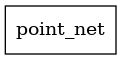

In [18]:
tf.keras.utils.plot_model(model, "pointnet_sketch.png",show_shapes=True)

# load model from .h5 file

In [23]:
model.load_weights("model.h5")

# loss function

In [19]:
def get_loss(pred,label,f_transform, reg_weight=0.001):
    """ pred: B*NUM_CLASSES,
        label: B, """
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=label)
    classify_loss = tf.reduce_mean(loss)
    tf.summary.scalar('classify loss', classify_loss)

    # Enforce the transformation as orthogonal matrix
    # BxKxK
    K = f_transform.shape[1]
    mat_diff = tf.matmul(f_transform, tf.transpose(f_transform, perm=[0,2,1])) # T * T^t
    mat_diff -= tf.constant(np.eye(K), dtype=tf.float32) # T * T^t - I_K
    mat_diff_loss = tf.nn.l2_loss(mat_diff) 
    tf.summary.scalar('mat loss', mat_diff_loss)

    return classify_loss + mat_diff_loss * reg_weight

In [20]:
class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, K, l2reg=0.001):
        self.K = K
        self.l2reg = l2reg
        self.eye = tf.eye(K)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.K, self.K))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.K, self.K))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [21]:
class ExponentialDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    """A LearningRateSchedule that uses an exponential decay schedule.
    Returns:
      A 1-arg callable learning rate schedule that takes the current optimizer
      step and outputs the decayed learning rate, a scalar `Tensor` of the same
      type as `initial_learning_rate`.
      modification: clips the learning rate !
    """

    def __init__(self,initial_learning_rate,decay_steps,decay_rate,staircase=False,name=None):
        """Applies exponential decay to the learning rate.
        Args:
          initial_learning_rate: A scalar `float32` or `float64` `Tensor` or a
            Python number.  The initial learning rate.
          decay_steps: A scalar `int32` or `int64` `Tensor` or a Python number.
            Must be positive.  See the decay computation above.
          decay_rate: A scalar `float32` or `float64` `Tensor` or a
            Python number.  The decay rate.
          staircase: Boolean.  If `True` decay the learning rate at discrete
            intervals
          name: String.  Optional name of the operation.  Defaults to
            'ExponentialDecay'.
        """
        super(ExponentialDecay, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.staircase = staircase
        self.name = name

    def __call__(self, step,bn=False):
        step=step*BATCH_SIZE
        with tf.name_scope(self.name or "ExponentialDecay") as name:
            initial_learning_rate = tf.convert_to_tensor(
                                 self.initial_learning_rate, name="initial_learning_rate")
            dtype = initial_learning_rate.dtype
            decay_steps = tf.cast(self.decay_steps, dtype)
            decay_rate = tf.cast(self.decay_rate, dtype)
            global_step_recomp = tf.cast(step, dtype)
            p = global_step_recomp / decay_steps
            
            if self.staircase:
                p = tf.floor(p)
            
            #clip it or batch_normalization decay!
            if not bn:
                #print(f"LOG: learning rate step {step}")
                return tf.maximum(tf.multiply(initial_learning_rate, tf.pow(decay_rate, p), name=name), 0.00001)
            else:
                #print(f"LOG: decays rate step {step}")
                return tf.minimum(1 - tf.multiply(initial_learning_rate, tf.pow(decay_rate, p), name=name), 0.99)
            
    def get_config(self):
        return {
        "initial_learning_rate": self.initial_learning_rate,
        "decay_steps": self.decay_steps,
        "decay_rate": self.decay_rate,
        "staircase": self.staircase,
        "name": self.name}

In [22]:
def shuffle_data(data, labels):
    """ Shuffle data and labels.
        Input:
          data: B,N,... numpy array
          label: B,... numpy array
        Return:
          shuffled data, label and shuffle indices
    """
    idx = np.arange(len(labels))
    np.random.shuffle(idx)
    return data[idx, ...], labels[idx], idx

def rotate_point_cloud(batch_data):
    """ Randomly rotate the point clouds to augument the dataset
        rotation is per shape based along up direction
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data

def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    """ Randomly jitter points. jittering is per point.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, jittered batch of point clouds
    """
    B, N, C = batch_data.shape
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1*clip, clip)
    jittered_data += batch_data
    return jittered_data




def rotate_point_cloud_by_angle(batch_data, rotation_angle):
    """ Rotate the point cloud along up direction with certain angle.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        #rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data

In [23]:
def train(epoch_num=MAX_EPOCH):
    
    is_training = True
    
    # learning rate
    lr = ExponentialDecay(BASE_LEARNING_RATE, DECAY_STEP, DECAY_RATE, staircase=True)
    optimizer = tf.optimizers.Adam(lr)
    
    # batch normalization schedualer
    bn = ExponentialDecay(BN_INIT_DECAY, BN_DECAY_DECAY_STEP, BN_DECAY_DECAY_RATE, staircase=True)
    
    for epoch in range(epoch_num):
        print(f"LOG: EPOCH NUMBER: {epoch}")
        train_one_epoch(epoch, optimizer, bn, is_training)
        
    # Save the model
    model.save_weights('./model.h5') 

def train_one_epoch(epoch, optimizer, bn, is_training):
    """ ops: dict mapping from string to tf ops """
    
    # Shuffle train files
    train_file_idxs = np.arange(0, len(TRAIN_FILES))
    np.random.shuffle(train_file_idxs)
    
    for fn in range(len(TRAIN_FILES)):
    
        current_data, current_label =  load_h5(TRAIN_FILES[train_file_idxs[fn]])
        current_data = current_data[:,0:MAX_NUM_POINT,:]
        current_data, current_label, _ = shuffle_data(current_data, np.squeeze(current_label))            
        current_label = np.squeeze(current_label)
        
        file_size = current_data.shape[0]
        num_batches = file_size // BATCH_SIZE
        
        total_correct = 0
        total_seen = 0
        loss_sum = 0

        for batch_idx in range(num_batches):
        
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE
        
            point_cloud, labels = current_data[start_idx:end_idx], current_label[start_idx:end_idx]
            rotated_data = rotate_point_cloud(point_cloud) #rotate batch
            jittered_data = jitter_point_cloud(rotated_data) #jitter batch
            jittered_data = tf.cast(jittered_data, 'float32') #casting float64 to float32, otherwise you get dtype error.   
            labels = np.squeeze(tf.cast(labels,tf.int64)) #omit redundent dimension 

            #decay
            #bn_decay = bn(optimizer.iterations.numpy(),bn=True)
            #print(f"LOG - bn_decay,step: {bn_decay} , {optimizer.iterations.numpy()}")
            #print(f"optimizer iterations: {optimizer.iterations}")
            
            #training step
            pred,loss= train_step(model, jittered_data, labels, optimizer, bn_decay=None, is_training=True)
            
            
            pred_val = np.argmax(pred, 1) # Returns the indices of the maximum values along an axis.
            correct = np.sum(pred_val == np.squeeze(current_label[start_idx:end_idx]))
            total_correct += correct
            total_seen += BATCH_SIZE
            loss_sum += loss
        
        with writer.as_default():
            tf.summary.scalar('loss', loss, step=epoch)
            tf.summary.scalar('accuracy',total_correct/total_seen , step=epoch)
            
        print(f"training - accuracy: {total_correct/total_seen}")
        
        
    _,eval_acc,_ = eval_one_epoch()
    with writer.as_default():
        tf.summary.scalar('eval_accuracy',eval_acc , step=epoch)
              
def train_step(model, inputs , labels, optimizer, bn_decay=None, is_training=True):
    
    #single model iteration for tensorBoard graph's plot.
    #pred, end_points = model(inputs)
    
    with tf.GradientTape() as tape:
        tf.summary.trace_on()
        pred, end_points = model(inputs, is_training=True)
        with writer.as_default():
             tf.summary.trace_export(
             name="my_func_trace",
             step=0,
             profiler_outdir=logdir)
        loss = get_loss(pred, labels ,end_points)
        
    grads = tape.gradient(loss , model.trainable_weights)
    
    optimizer.apply_gradients(
    (grad, var) 
    for (grad, var) in zip(grads, model.trainable_variables) 
    if grad is not None)
    
    return pred,loss        


# Evaluation

In [27]:
def eval_one_epoch(num_votes=1, topk=1):
    
    error_cnt = 0
    is_training = False
    total_correct = 0
    total_seen = 0
    loss_sum = 0
    
    total_seen_class = [0 for _ in range(NUM_CLASSES)]
    total_correct_class = [0 for _ in range(NUM_CLASSES)]
    
    for fn in range(len(TEST_FILES)):

        current_data, current_labels = load_h5(TEST_FILES[fn])
        current_data = current_data[:,0:MAX_NUM_POINT,:]
        current_labels = np.squeeze(current_labels)
        
        file_size = current_data.shape[0]
        num_batches = file_size // BATCH_SIZE
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE
            cur_batch_size = end_idx - start_idx
            
            # Aggregating BEG
            batch_loss_sum = 0 # sum of losses for the batch
            batch_pred_sum = np.zeros((cur_batch_size, NUM_CLASSES)) # score for classes
            batch_pred_classes = np.zeros((cur_batch_size, NUM_CLASSES)) # 0/1 for classes
            
            
            point_cloud, labels = current_data[start_idx:end_idx], current_labels[start_idx:end_idx]
            
            
            for vote_idx in range(num_votes):
                rotated_data = rotate_point_cloud_by_angle(point_cloud,
                                                  vote_idx/float(num_votes) * np.pi * 2)
               
                pred, end_points = model(rotated_data, is_training=False)
                labels = np.squeeze(tf.cast(labels,tf.int64))
                
                loss = get_loss(pred, labels ,end_points)
                
                batch_pred_sum += pred
                batch_pred_val = np.argmax(pred, 1)
                for el_idx in range(cur_batch_size):
                    batch_pred_classes[el_idx, batch_pred_val[el_idx]] += 1
                batch_loss_sum += (loss * cur_batch_size / float(num_votes))
    
            pred_val = np.argmax(batch_pred_sum, 1)
            # Aggregating END
            
            correct = np.sum(pred_val == current_labels[start_idx:end_idx])
            
            total_correct += correct
            total_seen += cur_batch_size
            loss_sum += batch_loss_sum

            for i in range(start_idx, end_idx):
                l = int(current_labels[i])
                total_seen_class[l] += 1
                total_correct_class[l] += (pred_val[i-start_idx] == l)
    
    eval_loss=loss_sum / float(total_seen)
    eval_acc=total_correct / float(total_seen)
    eval_avg_class_accuracies = np.mean(np.array(total_correct_class)/np.array(total_seen_class,dtype=np.float))
    
    print(f'eval mean loss: {eval_loss}')
    print(f'eval accuracy: {eval_acc}')
    print(f'eval avg class acc: {eval_avg_class_accuracies}')
    
    return eval_loss,eval_acc,eval_avg_class_accuracies

## train()

In [ ]:
train()

In [24]:
%tensorboard --logdir $logdir

In [44]:
eval_one_epoch()

(2048, 2048, 3)
2048
(420, 2048, 3)
420
eval mean loss: 0.7417102456092834
eval accuracy: 0.804788961038961
eval avg class acc: 0.7539131766166649


0.804788961038961